In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gzip
import json
import csv
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import hashlib
from sklearn.model_selection import train_test_split
import regex
from collections import Counter
import os

In [ ]:
folder_path = "/content/drive/MyDrive/Datasets/"

In [ ]:
electronics_path = folder_path + "Electronics.jsonl"
clothing_shoes_jewelry_path = folder_path + "Clothing_Shoes_and_Jewelry.jsonl"
arts_crafts_sewing_path = folder_path + "Arts_Crafts_and_Sewing.jsonl"
beauty_personal_care_path = folder_path + "Beauty_and_Personal_Care.jsonl"
sports_outdoors_path = folder_path + "Sports_and_Outdoors.jsonl"
grocery_gourmet_food_path = folder_path + "Grocery_and_Gourmet_Food.jsonl"

In [ ]:
# Display entire rows in DataFrames with no truncation
pd.set_option("display.max_colwidth", None)

### Functions

In [ ]:
def decompress_and_extract(compressed_file, output_file, columns=['title', 'text', 'rating']):
    '''
    Decompresses a compressed JSONL file, extracts the columns and saves the extracted data to an output file.
    '''
    skipped_count = 0

    # Open the compressed file in text mode
    with gzip.open(compressed_file, 'rt', encoding='utf-8') as f_in:
        # Open the output file in text write mode
        with open(output_file, 'w', encoding='utf-8') as f_out:
            for line in f_in:
                try:
                    # Parse the line as JSON
                    row = json.loads(line)
                    # Extract the columns
                    extracted_row = {key: row.get(key) for key in columns}
                    # Write the extracted record as a JSON object
                    f_out.write(json.dumps(extracted_row) + '\n')
                except json.JSONDecodeError:
                    # Count and skip malformed lines
                    skipped_count += 1

    # Print summary after processing
    print(f"Decompression and extraction complete. Total malformed lines skipped: {skipped_count}")

In [ ]:
def plot_counts(file_path, plot_title, column='rating'):
    """
    Plots the distribution of the specified column of a JSONL file.
    """
    values = []
    with open(file_path, 'r') as file:
        for line in file:
            row = json.loads(line.strip())
            values.append(row[column])

    # Create a count plot
    sns.set(style="whitegrid")
    ax = sns.countplot(x=values)

    # Get the total number of ratings
    total_count = len(values)

    # Label the proportions on the bars
    for p in ax.patches:
        height = p.get_height()
        proportion = height / total_count
        ax.text(p.get_x() + p.get_width() / 2., height + 0.05, f'{proportion:.2%}',
                ha="center", fontsize=10)

    # Add titles and labels
    plt.title(plot_title)
    plt.xlabel(column.capitalize())
    plt.ylabel('Count')
    plt.show()

In [ ]:
def find_invalid_values_jsonl(file_path, max_rows=1_000_000):
    '''
    Checks a JSONL file for invalid values in the title and text column.
    '''
    pattern = regex.compile(r"(?i)([a-z]\p{P}*a|none?|\p{P}+|\[\[VIDEOID:[a-f0-9]{32}\]\])")

    processed_rows = 0
    invalid_title_rows = 0
    invalid_text_rows = 0

    with open(file_path, 'r') as file:
        for line in file:
            # Stop after processing max_rows
            if processed_rows >= max_rows:
                break

            # Parse JSON and check the title and text columns
            data = json.loads(line)
            for field in ['title', 'text']:
                if pattern.fullmatch(data[field]):
                    print(data)
                    if field == 'title':
                        invalid_title_rows += 1
                    else:
                        invalid_text_rows += 1

            processed_rows += 1

    # Return results
    print(f"Total processed rows: {processed_rows}")
    print(f"Invalid title rows: {invalid_title_rows}")
    print(f"Invalid text rows: {invalid_text_rows}")

In [ ]:
def process_row(row):
        """
        Validates and processes title and text and maps rating to a sentiment category.
        """
        title = row.get('title', '')
        text = row.get('text', '')

        # Handle NaN values
        if pd.isna(title):
            title = ''
        if pd.isna(text):
            text = ''

        invalid_pattern = regex.compile(r"(?i)([a-z]\p{P}*a|none?|\p{P}+|\[\[VIDEOID:[a-f0-9]{32}\]\])")
        videoid_pattern = regex.compile(r"\[\[VIDEOID:[a-f0-9]+\]\]")

        # Check if 'title' or 'text' is invalid
        is_title_invalid = not title or bool(invalid_pattern.fullmatch(title))
        is_text_invalid = not text or bool(invalid_pattern.fullmatch(text))

        # Skip row if both 'title' and 'text' are invalid
        if is_title_invalid and is_text_invalid:
            return None
        # Keep 'title' only if 'text' is invalid, remove any video IDs
        elif is_text_invalid:
            review = videoid_pattern.sub('', title) if videoid_pattern.search(title) else title
        # Keep 'text' only if 'title' is invalid, remove any video IDs
        elif is_title_invalid:
            review = videoid_pattern.sub('', text) if videoid_pattern.search(text) else text
        # Keep 'text' only if 'title' is a substring of 'text', remove any video IDs
        elif title in text:
            review = videoid_pattern.sub('', text) if videoid_pattern.search(text) else text
        # Combine 'title' and 'text' if both are valid and 'title' is not a substring of 'text', remove any video IDs
        else:
            combined = f"{title} {text}"
            review = videoid_pattern.sub('', combined) if videoid_pattern.search(combined) else combined

        # Map rating to sentiment
        rating = row['rating']
        if rating in {1, 2}:
            sentiment = 0
        elif rating == 3:
            sentiment = 1
        elif rating in {4, 5}:
            sentiment = 2
        else:
            # Skip row if not a valid rating
            return None

        # Add the processed 'review' and 'sentiment' (mapped rating) columns to the row and drop 'title' and 'text'
        row['review'] = review
        row['sentiment'] = sentiment
        row.pop('title', None)
        row.pop('text', None)
        return row

In [ ]:
def stratified_sampling_train(json_file, proportion_dict, train_ratio, total_rows):
    """
    Reads a JSON file and creates a training set using stratified sampling based on the provided rating proportions.
    """
    # Set the random seed for reproducibility
    random.seed(42)

    # Calculate the number of training rows overall and per rating
    train_size = int(total_rows * train_ratio)
    train_targets = {rating: int(train_size * proportion) for rating, proportion in proportion_dict.items()}

    # Create a dictionary to group rows by rating
    rating_groups = {rating: [] for rating in proportion_dict.keys()}
    # Create a set for tracking row tuples added to the train set to avoid duplicate rows
    added_tuples = set()

    # Read and process each row from the JSON file
    with open(json_file, 'r', encoding='utf-8') as infile:
        for line in infile:
            row = json.loads(line)
            rating = row['rating']
            if rating in rating_groups:
                # Validate the row
                validated_row = process_row(row)
                if validated_row:
                    # Create a tuple for the current validated row
                    row_tuple = (validated_row['review'], validated_row['sentiment'])
                    # Only add the row if it has not been added before
                    if row_tuple not in added_tuples:
                        rating_groups[rating].append(validated_row)
                        added_tuples.add(row_tuple)


    # Collect the target number of rows for each rating category
    train_data = []
    for rating, rows in rating_groups.items():
        # Shuffle rows
        random.shuffle(rows)
        target = train_targets[rating]
        train_data.extend(rows[:target])

    # Convert to DataFrame
    train_df = pd.DataFrame(train_data)
    return train_df

In [ ]:
def sampling_val_test(json_file, combined_train_df, train_ratio, test_ratio, total_rows):
    """
    Reads a JSON file and creates validation and test sets.
    Excludes all rows that were assigned to any training set by checking if their (review, sentiment)
    tuple exists in the training sets.
    """
    random.seed(42)

    # Calculate the sizes for the training, validation and test sets
    train_size = int(total_rows * train_ratio)
    test_size = int(total_rows * test_ratio)
    val_size = total_rows - train_size - test_size

    # Create a set of tuples from the training sets to check that no training rows are assigned to the validation and test sets
    train_row_tuples = set(combined_train_df.apply(lambda row: (row['review'], row['sentiment']), axis=1))
    # Create a set for tracking row tuples added to the validation/test set to avoid duplicate rows
    added_tuples = set()

    remaining_data = []

    # Read the JSON file and collect rows not in seen_hashes
    with open(json_file, 'r', encoding='utf-8') as infile:
        for line in infile:
            row = json.loads(line)
            validated_row = process_row(row)
            if validated_row:
                # Create a tuple for the current validated row
                row_tuple = (validated_row['review'], validated_row['sentiment'])
                if row_tuple not in train_row_tuples and row_tuple not in added_tuples:
                    remaining_data.append(validated_row)
                    added_tuples.add(row_tuple)

    # Shuffle rows
    random.shuffle(remaining_data)

    # Allocate the remaining rows to the validation and test sets
    test_data = remaining_data[:test_size]
    val_data = remaining_data[test_size:test_size + val_size]

    # Convert to DataFrame
    val_df = pd.DataFrame(val_data)
    test_df = pd.DataFrame(test_data)
    return val_df, test_df

In [ ]:
def calculate_proportions(df, set_name, column='rating'):
    '''
    Calculates and prints the proportions of each value in the specified column.
    '''
    proportions = df[column].value_counts(normalize=True).sort_index()
    print(f"{set_name} proportions:")
    for value, proportion in proportions.items():
        print(f"{column.capitalize()} {value}: {proportion:.2%}")

In [ ]:
def save_df_to_csv(df, folder_path, file_name):
    """
    Saves a DataFrame to a CSV file in a specified folder.
    """
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)

    # Construct the file path
    file_path = os.path.join(folder_path, file_name)

    # Save the DataFrame to the CSV file
    df.to_csv(file_path, index=False, encoding='utf-8')

In [ ]:
def create_train_sets(json_file, dataset_name, proportion_dicts, folder_path, train_ratio=0.7, total_rows=1_500_000):
    """
    Creates training sets from a JSON file.
    """
    train_file_names = []

    # Iterate through the list of rating proportion dictionaries and create a training set according to the corresponding rating proportions
    for i, proportion_dict in enumerate(proportion_dicts, start=1):
        train_df = stratified_sampling_train(json_file, proportion_dict, train_ratio, total_rows)
        print(f"Train set {i}: {len(train_df)} rows")

        # Verify that rating proportions in the training set matches the rating proportion dictionary
        calculate_proportions(train_df, f"Train set {i}")

        # Drop the rating column
        train_df.drop(columns=['rating'], inplace=True)

        # Save the training set to CSV
        train_file_name = f"{dataset_name}_train_{i}.csv"
        save_df_to_csv(train_df, folder_path, train_file_name)
        train_file_names.append(train_file_name)

    return train_file_names

In [ ]:
def create_val_test_sets(json_file, dataset_name, folder_path, train_file_names, train_ratio=0.7, test_ratio=0.15, total_rows=1_500_000):
    """
    Creates validation and test sets from a JSON file.
    """
    # Combine the training sets into one DataFrame
    train_file_paths = [os.path.join(folder_path, file_name) for file_name in train_file_names]
    train_dfs = [pd.read_csv(file) for file in train_file_paths]
    combined_train_df = pd.concat(train_dfs, ignore_index=True)

    # Create the validation and test sets from rows that are not allocated to the training set
    val_df, test_df = sampling_val_test(json_file, combined_train_df, train_ratio, test_ratio, total_rows)
    print(f"Validation set: {len(val_df)} rows")
    print(f"Test set: {len(test_df)} rows")

    # Drop the rating column
    val_df.drop(columns=['rating'], inplace=True)
    test_df.drop(columns=['rating'], inplace=True)

    # Save the validation and test sets to CSV
    val_file_name = f"{dataset_name}_val.csv"
    test_file_name = f"{dataset_name}_test.csv"
    save_df_to_csv(val_df, folder_path, val_file_name)
    save_df_to_csv(test_df, folder_path, test_file_name)

In [ ]:
def verify_duplication(folder_path, file_names):
    """
    Checks for duplicate rows across one or more datasets.
    """
    # Read each CSV into a DataFrame
    dfs = []
    file_paths = [os.path.join(folder_path, file_name) for file_name in file_names]
    for file in file_paths:
        df = pd.read_csv(file)
        dfs.append(df)

    # Combine all DataFrames into one
    combined_df = pd.concat(dfs, ignore_index=True)

    # Identify all duplicate rows across the combined DataFrame
    duplicates = combined_df[combined_df.duplicated()]

    return duplicates

In [ ]:
def combine_csvs(file_names, folder_path, output_file_name):
    """
    Combines multiple CSV files into a single DataFrame and saves it to a CSV file.
    """
    # Construct the file paths
    file_paths = [os.path.join(folder_path, file_name) for file_name in file_names]

    # Read each CSV file into a DataFrame and store in a list
    dfs = [pd.read_csv(file_path) for file_path in file_paths]

    # Concatenate the DataFrames
    combined_df = pd.concat(dfs, ignore_index=True)

    # Save the combined DataFrame to a CSV file
    save_df_to_csv(combined_df, folder_path, output_file_name)

    return combined_df

# Decompressing the datasets

In [ ]:
# Decompressing the electronics dataset and extracting the 'title', 'text' and 'rating' columns
compressed_file = "/content/drive/MyDrive/Datasets/Electronics.jsonl.gz"
electronics_path = folder_path + "Electronics.jsonl"
decompress_and_extract(compressed_file, electronics_path)

In [ ]:
# Decompressing the clothes, shoes and jewelry dataset and extracting the 'title', 'text' and 'rating' columns
compressed_file = "/content/drive/MyDrive/Datasets/Clothing_Shoes_and_Jewelry.jsonl.gz"
decompress_and_extract(compressed_file, clothing_shoes_jewelry_path)

In [ ]:
# Decompressing the arts, crafts and sewing dataset and extracting the 'title', 'text' and 'rating' columns
compressed_file = "/content/drive/MyDrive/Datasets/Arts_Crafts_and_Sewing.jsonl.gz"
decompress_and_extract(compressed_file, arts_crafts_sewing_path)

In [ ]:
# Decompressing the beauty and personal care dataset and extracting the 'title', 'text' and 'rating' columns
compressed_file = "/content/drive/MyDrive/Datasets/Beauty_and_Personal_Care.jsonl.gz"
decompress_and_extract(compressed_file, beauty_personal_care_path)

In [ ]:
# Decompressing the sports and outdoors dataset and extracting the 'title', 'text' and 'rating' columns
compressed_file = "/content/drive/MyDrive/Datasets/Sports_and_Outdoors.jsonl.gz"
decompress_file(compressed_file, sports_outdoors_path)

In [ ]:
# Decompressing the grocery and gourmet food and extracting the 'title', 'text' and 'rating' columns
compressed_file = "/content/drive/MyDrive/Datasets/Grocery_and_Gourmet_Food.jsonl.gz"
decompress_and_extract(compressed_file, grocery_gourmet_food_path)

### extracting (temp - to be deleted)

In [ ]:
extract_columns(electronics_path, electronics_path) #21.06GB -> 12.56GB

In [ ]:
extract_columns(clothing_shoes_jewelry_path, clothing_shoes_jewelry_path) #25.9GB -> 12.92GB

In [ ]:
extract_columns(arts_crafts_sewing_path, arts_crafts_sewing_path) #3.67GB -> 1.78GB

In [ ]:
extract_columns(beauty_personal_care_path, beauty_personal_care_path) #10.26GB -> 5.39GB

In [ ]:
extract_columns(sports_outdoors_path, sports_outdoors_path) #8.62GB -> 4.76GB

# Exploring the datasets

In [ ]:
# Previewing the electronics dataset
electronics_df = pd.read_json(electronics_path, lines=True, nrows=10)
electronics_df

,title,text,rating
0,Smells like gasoline! Going back!,"First & most offensive: they reek of gasoline so if you are sensitive/allergic to petroleum products like I am you will want to pass on these. Second: the phone adapter is useless as-is. Mine was not drilled far enough to be able to tighten it into place for my iPhone 12 max. It just slipped & slid all over. Stupid me putting the adapter together first without picking up the binoculars to smell them bc I wasted 15 minutes trying to figure out how to put the adapter together bc it does not come with instructions! I had to come back here to the website which was a total pain. Third: the tripod is also useless. I would not trust the iOS to hold my $1600 phone nor even a Mattel Barbie for that matter. It’s just inefficient for the job imo. Third: in order to try to give an honest review I did don gloves & eyewear to check the binoculars out. They seemed average except for mine seemed to be missing about 10% of the film costing in the lower edge of one of the lenses which would have ruined every video & photograph unplanned to take so for me these are a very huge hard pass. I expect the accessories that come with the main product to be as good or better than the product I’m buying. Otherwise I would just buy the product as a stand alone. Sadly, I found a decent pair of binoculars last year with a much better quality phone adapter & tripod, but they had a defect too. Guess I’m going to have to pay more. Ugh.",3
1,Didn’t work at all lenses loose/broken.,"These didn’t work. Idk if they were damaged in shipping or what, but the lenses were loose or something. I could see half a lens with its edge in the frame and the rest was missing. It looked like it came loose or was broken.",1
2,Excellent!,"I love these. They even come with a carry case and several sizes of ear bud inserts. Thank heaven! I get ear pain from most, but the smallest buds fit great. They also have a charger and all of it fits in the carry case. I just wish they came in more colors preferably something bright! When I leave them on my nightstand it takes a while to figure out which of half a dozen black cables are the right ones. Even white would be ok as only my iPhone has a white cord.",5
3,Great laptop backpack!,"I was searching for a sturdy backpack for school that would allow me to carry my laptop as well as schoolbooks. After reading many of the reviews of this bag, I placed my order and crossed my fingers. I shouldn't have worried; it's a great bag! Solidly built and traveler-friendly with a ton of compartments for every little thing one might need to stow away. While this backpack is slightly larger than your average backpack, it is comfortable to wear trekking cross campus. Also, another aspect of this bag that I love is that it stands upright. I know that sounds kinda crazy, but I find it annoying when your backpack flops over next to your desk and stuff kind of just falls out, or if you need to grab something quickly out of the bag you have to awkwardly curl your body around the side of your chair and then on the way up, smash your head against the desk. So yeah, lazy girl (points to self) loves the convenience of a bag that stands upright for easy grabbage. I plan to travel with this backpack when I fly home this Christmas instead of bringing a bulky tote bag on the plane.",5
4,Best Headphones in the Fifties price range!,I've bought these headphones three times because I love them so much and overuse them and find ways to break the plug to where I can't use my warranty. The sound and bass are awesome. Hands down my favorite headphones in this price bracket.,5
5,Great Fan! I’m a FAN!,"Light weight, quiet and totally awesome!!! It doesn’t come with a charging base, but the cord ends in a USB so you can plug it into a phone charger or portable charger. Anything with USB! It’s so light and works great! It’s really quiet also!!!",5
6,solid sound for the price,Update 2-they sent a new warranty replacement. Goo

### Visualising the distribution of ratings

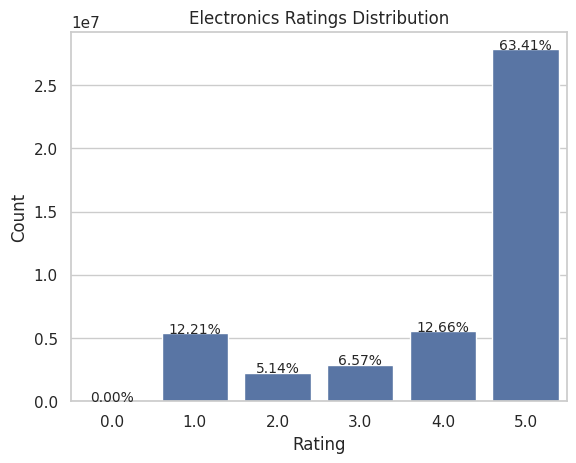

In [ ]:
plot_counts(electronics_path, "Electronics Ratings Distribution")

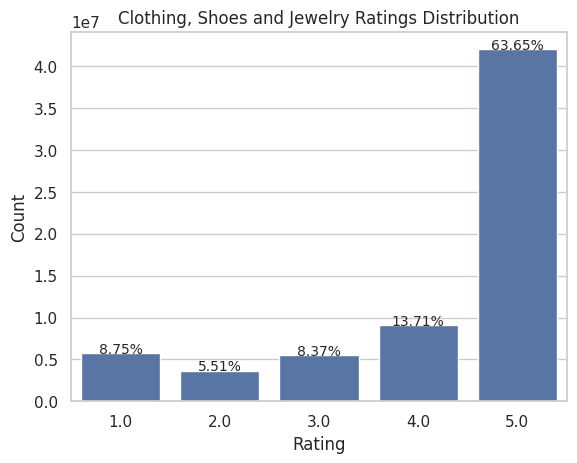

In [ ]:
plot_counts(clothing_shoes_jewelry_path, "Clothing, Shoes and Jewelry Ratings Distribution")

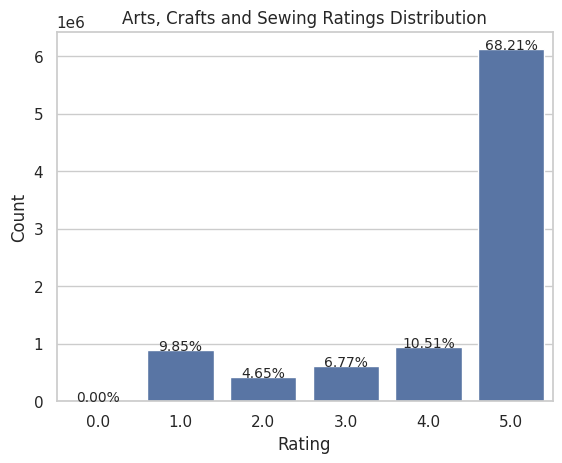

In [ ]:
plot_counts(arts_crafts_sewing_path, "Arts, Crafts and Sewing Ratings Distribution")

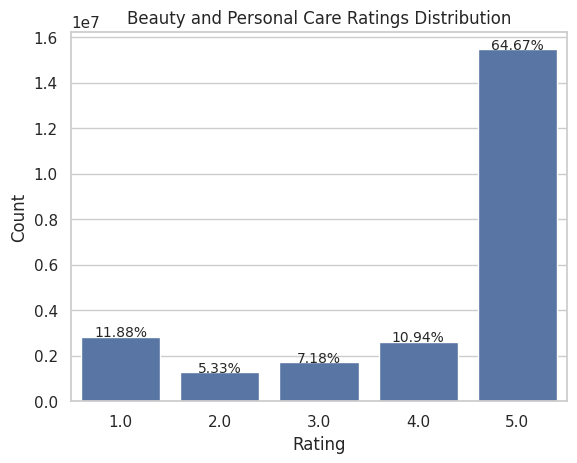

In [ ]:
plot_counts(beauty_personal_care_path, "Beauty and Personal Care Ratings Distribution")

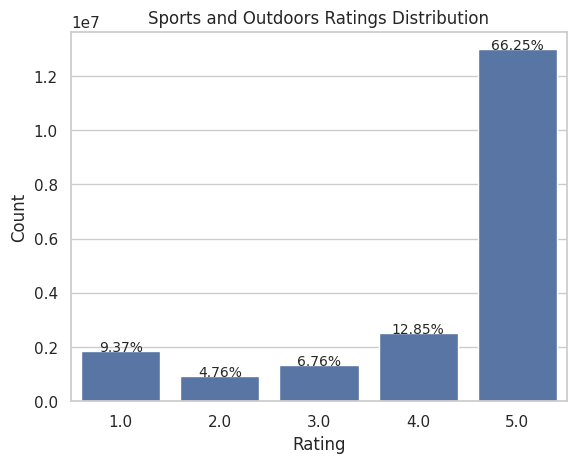

In [ ]:
plot_counts(sports_outdoors_path, "Sports and Outdoors Ratings Distribution")

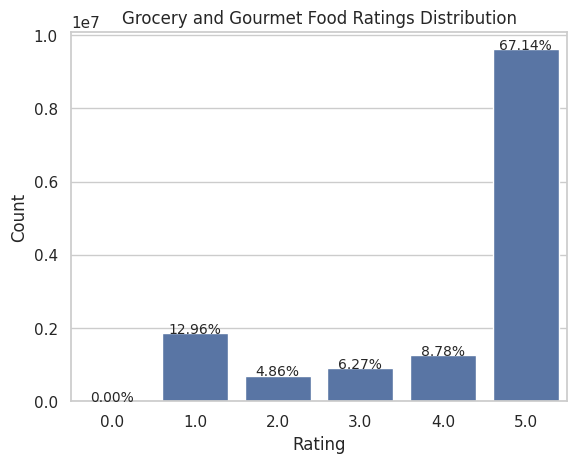

In [ ]:
plot_counts(grocery_gourmet_food_path, "Grocery and Gourmet Food Ratings Distribution")

### Exploring invalid values

In [ ]:
find_invalid_values_jsonl(electronics_path)

In [ ]:
find_invalid_values_jsonl(clothing_shoes_jewelry_path)

{'title': 'Na', 'text': 'Great.', 'rating': 5.0}
{'title': '.', 'text': 'Cute', 'rating': 5.0}
{'title': ':)', 'text': 'Son loves it', 'rating': 5.0}
{'title': 'good productGood product but not for me', 'text': 'N/A', 'rating': 5.0}
{'title': '*****', 'text': 'I love this wallet!', 'rating': 5.0}
{'title': '.', 'text': 'my wife says these are very comfortable.', 'rating': 5.0}
{'title': '..', 'text': 'Came late but Great product!!', 'rating': 5.0}
{'title': 'N/A', 'text': 'N/A', 'rating': 5.0}
{'title': 'N/A', 'text': 'N/A', 'rating': 5.0}
{'title': '.', 'text': 'not happy with the feel. Nothing wrong with the shoe, Skechers has me so spoiled that if a shoe doesnt feel like they do, they are not gonna get worn much is all.', 'rating': 5.0}
{'title': '.', 'text': 'Everything exactly as it should be. Item was as described, shipped and arrived when expected, and was packaged well for the journey. Cant really ask for more! Thanks!', 'rating': 2.0}
{'title': '.', 'text': 'Everything exactly

In [ ]:
find_invalid_values_jsonl(arts_crafts_sewing_path)

{'title': '.', 'text': "It's quite hard to get the candle out of the mold. I broke some of the design away trying to get it out. But it's very pretty and I'm going to keep trying different ways.", 'rating': 3.0}
{'title': 'N/A', 'text': 'N/A', 'rating': 5.0}
{'title': 'N/A', 'text': 'N/A', 'rating': 5.0}
{'title': 'N/A', 'text': 'N/A', 'rating': 5.0}
{'title': 'N/A', 'text': 'N/A', 'rating': 5.0}
{'title': 'N/A', 'text': 'N/A', 'rating': 5.0}
{'title': 'N/A', 'text': 'N/A', 'rating': 5.0}
{'title': 'N/A', 'text': 'N/A', 'rating': 5.0}
{'title': 'N/A', 'text': 'N/A', 'rating': 5.0}
{'title': '.', 'text': 'Shipped and arrived when expected, is what its supposed to be, does exactly what it should, no complaints.', 'rating': 5.0}
{'title': 'Na', 'text': 'Na', 'rating': 5.0}
{'title': 'Na', 'text': 'Na', 'rating': 5.0}
{'title': '!', 'text': 'Bought these as a gift for my cousin and he loves ut', 'rating': 5.0}
{'title': '.', 'text': 'Lots of colors', 'rating': 5.0}
{'title': '.', 'text': '

In [ ]:
find_invalid_values_jsonl(beauty_personal_care_path)

{'title': 'good product at the price point', 'text': 'n/a', 'rating': 5.0}
{'title': 'N/A', 'text': 'n/a', 'rating': 5.0}
{'title': 'N/A', 'text': 'n/a', 'rating': 5.0}
{'title': 'none', 'text': 'works great.', 'rating': 5.0}
{'title': 'na', 'text': 'lasts', 'rating': 5.0}
{'title': 'N/A', 'text': 'Wash body', 'rating': 4.0}
{'title': 'ok', 'text': 'n/a', 'rating': 3.0}
{'title': 'None', 'text': 'None', 'rating': 5.0}
{'title': 'None', 'text': 'None', 'rating': 5.0}
{'title': 'None', 'text': 'None', 'rating': 5.0}
{'title': 'None', 'text': 'None', 'rating': 5.0}
{'title': 'None', 'text': 'None', 'rating': 4.0}
{'title': 'None', 'text': 'None', 'rating': 4.0}
{'title': '.', 'text': 'None', 'rating': 4.0}
{'title': 'None', 'text': 'None', 'rating': 4.0}
{'title': 'None', 'text': 'None', 'rating': 4.0}
{'title': 'None', 'text': 'None', 'rating': 4.0}
{'title': 'None', 'text': 'None', 'rating': 4.0}
{'title': 'Five Stars', 'text': 'None', 'rating': 5.0}
{'title': 'N/A', 'text': 'Perfect', 

In [ ]:
find_invalid_values_jsonl(sports_outdoors_path)

{'title': '?', 'text': "Hadn't  hung yet", 'rating': 3.0}
{'title': '.', 'text': 'Shipped and arrived when expected, is what its supposed to be, does exactly what it should, no complaints.', 'rating': 5.0}
{'title': '.', 'text': 'Shipped and arrived when expected, is what its supposed to be, does exactly what it should, no complaints.', 'rating': 5.0}
{'title': 'nice colors and prestin graphics', 'text': '[[VIDEOID:d8a3aa1b0c662c1e6874eb09e90b237d]]', 'rating': 5.0}
{'title': ':)', 'text': 'Great for camping or for skiing. Stay on well and can get very hot.', 'rating': 5.0}
{'title': ':)', 'text': 'Incredible sandwich maker for campfires and even at home. Makes the sandwiches super toasty.', 'rating': 5.0}
{'title': ':)', 'text': 'Decent quality for the price', 'rating': 4.0}
{'title': ':)', 'text': 'So happy I bought this item! I’m in love &lt;3', 'rating': 5.0}
{'title': '.', 'text': 'Perfect', 'rating': 5.0}
{'title': '???', 'text': "I have no answer. I cannot review what I haven't 

In [ ]:
find_invalid_values_jsonl(grocery_gourmet_food_path)

{'title': 'Three cans came smashed around seal', 'text': '[[VIDEOID:349f4e3c3bb42c2a519bc03cda3e149b]]', 'rating': 3.0}
{'title': 'Rice is good and flavorful', 'text': 'N/a', 'rating': 5.0}
{'title': 'on time - as advertised.', 'text': 'n/a', 'rating': 5.0}
{'title': 'none', 'text': 'none', 'rating': 5.0}
{'title': 'none', 'text': 'none', 'rating': 5.0}
{'title': 'none', 'text': 'disliked', 'rating': 5.0}
{'title': 'Great Flavor, a Little Bit Goes a', 'text': '[[VIDEOID:1bc75e4a17f792febcc6aed21496cc1c]]', 'rating': 5.0}
{'title': 'N/A', 'text': 'Awsome', 'rating': 5.0}
{'title': 'N/A', 'text': 'Sweet and juicy.', 'rating': 5.0}
{'title': 'N/A', 'text': 'N/A', 'rating': 1.0}
{'title': 'N/A', 'text': 'N/A', 'rating': 1.0}
{'title': 'None', 'text': 'None', 'rating': 4.0}
{'title': 'None', 'text': 'None', 'rating': 4.0}
{'title': 'None', 'text': 'None', 'rating': 4.0}
{'title': 'None', 'text': 'None', 'rating': 4.0}
{'title': 'None', 'text': 'None', 'rating': 5.0}
{'title': 'None', 'text'

# Preparing the datasets

In [ ]:
total_rows = int(3_000_000/6)

In [ ]:
# Different rating proportions for each train set
proportions_1 = {1: 0.17, 2: 0.08, 3: 0.1, 4: 0.25, 5: 0.40} # 65% pos, 10% neu, 25% neg
proportions_2 = {1: 0.2, 2: 0.1, 3: 0.2, 4: 0.22, 5: 0.28} # 50% pos, 20% neu, 30% neg
proportions_3 = {1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2, 5: 0.2} # 33.3% pos, 33.3% neu, 33.3% neg

proportion_dicts = [proportions_1, proportions_2, proportions_3]

### Electronics - done

In [ ]:
dataset_name = "Electronics"

In [ ]:
# Creating the training sets with different rating proportions
train_file_names = create_train_sets(electronics_path, dataset_name, proportion_dicts, folder_path, total_rows=total_rows)

Train set 1: 350000 rows
Train set 1 proportions:
Rating 1.0: 17.00%
Rating 2.0: 8.00%
Rating 3.0: 10.00%
Rating 4.0: 25.00%
Rating 5.0: 40.00%
Train set 2: 350000 rows
Train set 2 proportions:
Rating 1.0: 20.00%
Rating 2.0: 10.00%
Rating 3.0: 20.00%
Rating 4.0: 22.00%
Rating 5.0: 28.00%
Train set 3: 350000 rows
Train set 3 proportions:
Rating 1.0: 20.00%
Rating 2.0: 20.00%
Rating 3.0: 20.00%
Rating 4.0: 20.00%
Rating 5.0: 20.00%


In [ ]:
# Creating the validation and test sets
create_val_test_sets(electronics_path, dataset_name, folder_path, train_file_names, total_rows=total_rows)

Validation set: 75000 rows
Test set: 75000 rows


In [ ]:
# Checking for duplicate rows in the training sets
for i in range(1, 4):
    file_name = f"{dataset_name}_train_{i}.csv"
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    duplicates = df[df.duplicated()]
    print(f"Total number of duplicate rows in train set {i}: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in train set 1: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in train set 2: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in train set 3: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




In [ ]:
# Checking for duplicate rows in the validation and test sets
files = [("validation", f"{dataset_name}_val.csv"), ("test", f"{dataset_name}_test.csv")]
for set_name, file_name in files:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    duplicates = df[df.duplicated()]
    print(f"Total number of duplicate rows in {set_name} set: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in validation set: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in test set: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




In [ ]:
# Verifying that no rows in the training set appear in the validation and test sets
for i in range(1, 4):
    file_names = [f"{dataset_name}_train_{i}.csv", f"{dataset_name}_val.csv", f"{dataset_name}_test.csv"]
    duplicates = verify_duplication(folder_path, file_names)
    print(f"Total number of duplicate rows in set {i}: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in set 1: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in set 2: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in set 3: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




### Clothing, shoes and jewelry - done

In [ ]:
dataset_name = "Clothing_Shoes_and_Jewelry"

In [ ]:
# Creating the training sets with different rating proportions
train_file_names = create_train_sets(clothing_shoes_jewelry_path, dataset_name, proportion_dicts, folder_path, total_rows=total_rows)

Train set 1: 350000 rows
Train set 1 proportions:
Rating 1.0: 17.00%
Rating 2.0: 8.00%
Rating 3.0: 10.00%
Rating 4.0: 25.00%
Rating 5.0: 40.00%
Train set 2: 350000 rows
Train set 2 proportions:
Rating 1.0: 20.00%
Rating 2.0: 10.00%
Rating 3.0: 20.00%
Rating 4.0: 22.00%
Rating 5.0: 28.00%
Train set 3: 350000 rows
Train set 3 proportions:
Rating 1.0: 20.00%
Rating 2.0: 20.00%
Rating 3.0: 20.00%
Rating 4.0: 20.00%
Rating 5.0: 20.00%


In [ ]:
# Creating the validation and test sets
create_val_test_sets(clothing_shoes_jewelry_path, dataset_name, folder_path, train_file_names, total_rows=total_rows)

Validation set: 75000 rows
Test set: 75000 rows


In [ ]:
# Checking for duplicate rows in the training sets
for i in range(1, 4):
    file_name = f"{dataset_name}_train_{i}.csv"
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    duplicates = df[df.duplicated()]
    print(f"Total number of duplicate rows in train set {i}: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in train set 1: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in train set 2: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in train set 3: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




In [ ]:
# Checking for duplicate rows in the validation and test sets
files = [("validation", f"{dataset_name}_val.csv"), ("test", f"{dataset_name}_test.csv")]
for set_name, file_name in files:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    duplicates = df[df.duplicated()]
    print(f"Total number of duplicate rows in {set_name} set: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in validation set: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in test set: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




In [ ]:
# Verifying that no rows in the training set appear in the validation and test sets
for i in range(1, 4):
    file_names = [f"{dataset_name}_train_{i}.csv", f"{dataset_name}_val.csv", f"{dataset_name}_test.csv"]
    duplicates = verify_duplication(folder_path, file_names)
    print(f"Total number of duplicate rows in set {i}: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in set 1: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in set 2: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in set 3: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




### Arts, crafts and sewing - done

In [ ]:
dataset_name = "Arts_Crafts_and_Sewing"

In [ ]:
# Creating the training sets with different rating proportions
train_file_names = create_train_sets(arts_crafts_sewing_path, dataset_name, proportion_dicts, folder_path, total_rows=total_rows)

Train set 1: 350000 rows
Train set 1 proportions:
Rating 1.0: 17.00%
Rating 2.0: 8.00%
Rating 3.0: 10.00%
Rating 4.0: 25.00%
Rating 5.0: 40.00%
Train set 2: 350000 rows
Train set 2 proportions:
Rating 1.0: 20.00%
Rating 2.0: 10.00%
Rating 3.0: 20.00%
Rating 4.0: 22.00%
Rating 5.0: 28.00%
Train set 3: 350000 rows
Train set 3 proportions:
Rating 1.0: 20.00%
Rating 2.0: 20.00%
Rating 3.0: 20.00%
Rating 4.0: 20.00%
Rating 5.0: 20.00%


In [ ]:
# Creating the validation and test sets
create_val_test_sets(arts_crafts_sewing_path, dataset_name, folder_path, train_file_names, total_rows=total_rows)

Validation set: 75000 rows
Test set: 75000 rows


In [ ]:
# Checking for duplicate rows in the training sets
for i in range(1, 4):
    file_name = f"{dataset_name}_train_{i}.csv"
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    duplicates = df[df.duplicated()]
    print(f"Total number of duplicate rows in train set {i}: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in train set 1: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in train set 2: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in train set 3: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




In [ ]:
# Checking for duplicate rows in the validation and test sets
files = [("validation", f"{dataset_name}_val.csv"), ("test", f"{dataset_name}_test.csv")]
for set_name, file_name in files:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    duplicates = df[df.duplicated()]
    print(f"Total number of duplicate rows in {set_name} set: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in validation set: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in test set: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




In [ ]:
# Verifying that no rows in the training set appear in the validation and test sets
for i in range(1, 4):
    file_names = [f"{dataset_name}_train_{i}.csv", f"{dataset_name}_val.csv", f"{dataset_name}_test.csv"]
    duplicates = verify_duplication(folder_path, file_names)
    print(f"Total number of duplicate rows in set {i}: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in set 1: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in set 2: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in set 3: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




### Beauty and personal care - done

In [ ]:
dataset_name = "Beauty_and_Personal_Care"

In [ ]:
# Creating the training sets with different rating proportions
train_file_names = create_train_sets(beauty_personal_care_path, dataset_name, proportion_dicts, folder_path, total_rows=total_rows)

Train set 1: 350000 rows
Train set 1 proportions:
Rating 1.0: 17.00%
Rating 2.0: 8.00%
Rating 3.0: 10.00%
Rating 4.0: 25.00%
Rating 5.0: 40.00%
Train set 2: 350000 rows
Train set 2 proportions:
Rating 1.0: 20.00%
Rating 2.0: 10.00%
Rating 3.0: 20.00%
Rating 4.0: 22.00%
Rating 5.0: 28.00%
Train set 3: 350000 rows
Train set 3 proportions:
Rating 1.0: 20.00%
Rating 2.0: 20.00%
Rating 3.0: 20.00%
Rating 4.0: 20.00%
Rating 5.0: 20.00%


In [ ]:
# Creating the validation and test sets
create_val_test_sets(beauty_personal_care_path, dataset_name, folder_path, train_file_names, total_rows=total_rows)

Validation set: 75000 rows
Test set: 75000 rows


In [ ]:
# Checking for duplicate rows in the training sets
for i in range(1, 4):
    file_name = f"{dataset_name}_train_{i}.csv"
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    duplicates = df[df.duplicated()]
    print(f"Total number of duplicate rows in train set {i}: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in train set 1: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in train set 2: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in train set 3: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




In [ ]:
# Checking for duplicate rows in the validation and test sets
files = [("validation", f"{dataset_name}_val.csv"), ("test", f"{dataset_name}_test.csv")]
for set_name, file_name in files:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    duplicates = df[df.duplicated()]
    print(f"Total number of duplicate rows in {set_name} set: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in validation set: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in test set: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




In [ ]:
# Verifying that no rows in the training set appear in the validation and test sets
for i in range(1, 4):
    file_names = [f"{dataset_name}_train_{i}.csv", f"{dataset_name}_val.csv", f"{dataset_name}_test.csv"]
    duplicates = verify_duplication(folder_path, file_names)
    print(f"Total number of duplicate rows in set {i}: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in set 1: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in set 2: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in set 3: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




### Sports and outdoors - done

In [ ]:
dataset_name = "Sports_and_Outdoors"

In [ ]:
# Creating the training sets with different rating proportions
train_file_names = create_train_sets(sports_outdoors_path, dataset_name, proportion_dicts, folder_path, total_rows=total_rows)

Train set 1: 350000 rows
Train set 1 proportions:
Rating 1.0: 17.00%
Rating 2.0: 8.00%
Rating 3.0: 10.00%
Rating 4.0: 25.00%
Rating 5.0: 40.00%
Train set 2: 350000 rows
Train set 2 proportions:
Rating 1.0: 20.00%
Rating 2.0: 10.00%
Rating 3.0: 20.00%
Rating 4.0: 22.00%
Rating 5.0: 28.00%
Train set 3: 350000 rows
Train set 3 proportions:
Rating 1.0: 20.00%
Rating 2.0: 20.00%
Rating 3.0: 20.00%
Rating 4.0: 20.00%
Rating 5.0: 20.00%


In [ ]:
# Creating the validation and test sets
create_val_test_sets(sports_outdoors_path, dataset_name, folder_path, train_file_names, total_rows=total_rows)

Validation set: 75000 rows
Test set: 75000 rows


In [ ]:
# Checking for duplicate rows in the training sets
for i in range(1, 4):
    file_name = f"{dataset_name}_train_{i}.csv"
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    duplicates = df[df.duplicated()]
    print(f"Total number of duplicate rows in train set {i}: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in train set 1: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in train set 2: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in train set 3: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




In [ ]:
# Checking for duplicate rows in the validation and test sets
files = [("validation", f"{dataset_name}_val.csv"), ("test", f"{dataset_name}_test.csv")]
for set_name, file_name in files:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    duplicates = df[df.duplicated()]
    print(f"Total number of duplicate rows in {set_name} set: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in validation set: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in test set: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




In [ ]:
# Verifying that no rows in the training set appear in the validation and test sets
for i in range(1, 4):
    file_names = [f"{dataset_name}_train_{i}.csv", f"{dataset_name}_val.csv", f"{dataset_name}_test.csv"]
    duplicates = verify_duplication(folder_path, file_names)
    print(f"Total number of duplicate rows in set {i}: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in set 1: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in set 2: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in set 3: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




### Grocery and gourmet food - done

In [ ]:
dataset_name = "Grocery_and_Gourmet_Food"

In [ ]:
# Creating the training sets with different rating proportions
train_file_names = create_train_sets(grocery_gourmet_food_path, dataset_name, proportion_dicts, folder_path, total_rows=total_rows)

Train set 1: 350000 rows
Train set 1 proportions:
Rating 1.0: 17.00%
Rating 2.0: 8.00%
Rating 3.0: 10.00%
Rating 4.0: 25.00%
Rating 5.0: 40.00%
Train set 2: 350000 rows
Train set 2 proportions:
Rating 1.0: 20.00%
Rating 2.0: 10.00%
Rating 3.0: 20.00%
Rating 4.0: 22.00%
Rating 5.0: 28.00%
Train set 3: 350000 rows
Train set 3 proportions:
Rating 1.0: 20.00%
Rating 2.0: 20.00%
Rating 3.0: 20.00%
Rating 4.0: 20.00%
Rating 5.0: 20.00%


In [ ]:
# Creating the validation and test sets
create_val_test_sets(grocery_gourmet_food_path, dataset_name, folder_path, train_file_names, total_rows=total_rows)

Validation set: 75000 rows
Test set: 75000 rows


In [ ]:
# Checking for duplicate rows in the training sets
for i in range(1, 4):
    file_name = f"{dataset_name}_train_{i}.csv"
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    duplicates = df[df.duplicated()]
    print(f"Total number of duplicate rows in train set {i}: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in train set 1: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in train set 2: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in train set 3: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




In [ ]:
# Checking for duplicate rows in the validation and test sets
files = [("validation", f"{dataset_name}_val.csv"), ("test", f"{dataset_name}_test.csv")]
for set_name, file_name in files:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    duplicates = df[df.duplicated()]
    print(f"Total number of duplicate rows in {set_name} set: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in validation set: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in test set: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




In [ ]:
# Verifying that no rows in the training set appear in the validation and test sets
for i in range(1, 4):
    file_names = [f"{dataset_name}_train_{i}.csv", f"{dataset_name}_val.csv", f"{dataset_name}_test.csv"]
    duplicates = verify_duplication(folder_path, file_names)
    print(f"Total number of duplicate rows in set {i}: {len(duplicates)}")
    print(duplicates)
    print("\n")

Total number of duplicate rows in set 1: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in set 2: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


Total number of duplicate rows in set 3: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []




# Combining the datasets

In [ ]:
dataset_names = ["Electronics", "Clothing_Shoes_and_Jewelry", "Arts_Crafts_and_Sewing", "Beauty_and_Personal_Care", "Sports_and_Outdoors", "Grocery_and_Gourmet_Food"]

In [ ]:
import itertools
for dataset_name, i in itertools.product(dataset_names, range(1, 4)):
    file_name = f"{dataset_name}_train_{i}.csv"
    df = pd.read_csv(os.path.join(folder_path, file_name))
    print(f"{dataset_name} {i}")
    print(df[df.isna().any(axis=1) | df.eq("").any(axis=1)])

Electronics 1
Empty DataFrame
Columns: [review, sentiment]
Index: []
Electronics 2
Empty DataFrame
Columns: [review, sentiment]
Index: []
Electronics 3
Empty DataFrame
Columns: [review, sentiment]
Index: []
Clothing_Shoes_and_Jewelry 1
Empty DataFrame
Columns: [review, sentiment]
Index: []
Clothing_Shoes_and_Jewelry 2
Empty DataFrame
Columns: [review, sentiment]
Index: []
Clothing_Shoes_and_Jewelry 3
Empty DataFrame
Columns: [review, sentiment]
Index: []
Arts_Crafts_and_Sewing 1
Empty DataFrame
Columns: [review, sentiment]
Index: []
Arts_Crafts_and_Sewing 2
Empty DataFrame
Columns: [review, sentiment]
Index: []
Arts_Crafts_and_Sewing 3
Empty DataFrame
Columns: [review, sentiment]
Index: []
Beauty_and_Personal_Care 1
Empty DataFrame
Columns: [review, sentiment]
Index: []
Beauty_and_Personal_Care 2
Empty DataFrame
Columns: [review, sentiment]
Index: []
Beauty_and_Personal_Care 3
Empty DataFrame
Columns: [review, sentiment]
Index: []
Sports_and_Outdoors 1
Empty DataFrame
Columns: [review,

In [ ]:
# Combining the train sets
proportion_sets = [(1, "65_10_25"), (2, "50_20_30"), (3, "33_33_33")]
for i, proportion_set in proportion_sets:
    file_names = [f"{dataset_name}_train_{i}.csv" for dataset_name in dataset_names]
    combine_csvs(file_names, folder_path, f"train_{proportion_set}.csv")

In [ ]:
train_1 = pd.read_csv(os.path.join(folder_path, "train_65_10_25.csv"))
train_1

,review,sentiment
0,Was good for a moment or two I was pleasantly surprised with the sound of these but that was very short lived.. I put these in boxes for some music in my kitchen using a kinter 4 watt per channel amplifier. They sounded really good for the price but the midrange/tweeter assembly came loose from the woofer and the midrange speaker blew! Spend a few more bucks on a decent pair of 6x9 speakers.. I did however get a refund very quickly on these from them having a defective speaker so the company selling them is cool.. Don't get mad at them for selling them but do invest in another speaker..,0
1,Stopped working within 2 weeks. Shuts off at high power usage.,0
2,Not enough information for devices that they can work with Did not work on any of my devices,0
3,"I bought this tablet as a backup to my Samsung. It's only been 45 days and the screen has lost its resolution. It now has the effect of a flat screen TV that you can't see from any other angle but dead-on. It wasn't like that for the first 44 dsyd. Of course, now it's outside of the 30 day return policy. I would not buy this again or recommend it to anyone.",0
4,Break easy As soon I pulled them tight they break immediately,0
...,...,...
2099995,Delicious morsels of heaven. Love these. Perfect snack.,2
2099996,absolutely delicious I ordered this the first time because I was curious what clotted cream fudge was. Now I can't stop ordering it because it is marvelous. I started to order more of Gardiner's products just to experiment and was delighted. A must for those of us with a sweet tooth for the unusual.,2
2099997,It’s a great deal! Loved when my coffee arrived. Getting ready for a reorder.,2
2099998,Just what you would expect Delicious and conveniently delivered,2


In [ ]:
train_2 = pd.read_csv(os.path.join(folder_path, "train_50_20_30.csv"))
train_2

,review,sentiment
0,Was good for a moment or two I was pleasantly surprised with the sound of these but that was very short lived.. I put these in boxes for some music in my kitchen using a kinter 4 watt per channel amplifier. They sounded really good for the price but the midrange/tweeter assembly came loose from the woofer and the midrange speaker blew! Spend a few more bucks on a decent pair of 6x9 speakers.. I did however get a refund very quickly on these from them having a defective speaker so the company selling them is cool.. Don't get mad at them for selling them but do invest in another speaker..,0
1,Stopped working within 2 weeks. Shuts off at high power usage.,0
2,Not enough information for devices that they can work with Did not work on any of my devices,0
3,"I bought this tablet as a backup to my Samsung. It's only been 45 days and the screen has lost its resolution. It now has the effect of a flat screen TV that you can't see from any other angle but dead-on. It wasn't like that for the first 44 dsyd. Of course, now it's outside of the 30 day return policy. I would not buy this again or recommend it to anyone.",0
4,Break easy As soon I pulled them tight they break immediately,0
...,...,...
2099995,The best tasting English Breakfast tea!! My very favorite tea. I haven’t found any English Breakfast tea with a better flavor.,2
2099996,Great snack! Great snack even if health foods aren't your thing. They are only a little bit spicy. I would love to order again but they are out of stock.,2
2099997,Gives your baked goods an extra dark chocolate look. Product perfect for giving cookies that dark Oreo appearance. Combine that with some bright white candy melts and you get a perfect contrast.,2
2099998,"Great healthy snack! I love this Kale snack! It’s crunchy and has great flavor. Only drawback is the price. But, unfortunately, eating healthy snacks is not cheap! Definitely will but again and recommend!",2


In [ ]:
train_3 = pd.read_csv(os.path.join(folder_path, "train_33_33_33.csv"))
train_3

,review,sentiment
0,Was good for a moment or two I was pleasantly surprised with the sound of these but that was very short lived.. I put these in boxes for some music in my kitchen using a kinter 4 watt per channel amplifier. They sounded really good for the price but the midrange/tweeter assembly came loose from the woofer and the midrange speaker blew! Spend a few more bucks on a decent pair of 6x9 speakers.. I did however get a refund very quickly on these from them having a defective speaker so the company selling them is cool.. Don't get mad at them for selling them but do invest in another speaker..,0
1,Stopped working within 2 weeks. Shuts off at high power usage.,0
2,Not enough information for devices that they can work with Did not work on any of my devices,0
3,"I bought this tablet as a backup to my Samsung. It's only been 45 days and the screen has lost its resolution. It now has the effect of a flat screen TV that you can't see from any other angle but dead-on. It wasn't like that for the first 44 dsyd. Of course, now it's outside of the 30 day return policy. I would not buy this again or recommend it to anyone.",0
4,Break easy As soon I pulled them tight they break immediately,0
...,...,...
2099995,"Quality depends on source: Denmark(very good), but Morocco(Poor) This mackerel is excellent if on the back it says ""Product of Denmark"". It is moist, flakey, tender, not too fishy, with great ""mouth feel. It is slightly salty, and the flavor of the oil is very nice.<br /><br />(However, if it says ""Product of Morocco"", it is unlike the Danish product. It will be much dryer, much less flakey, and I find the taste much less pleasing and slightly bitter. I would give the Moroccan product a 1 star rating.)<br /><br />I don't know why they change the source at times. It may be seasonal.",2
2099996,"This is my favorite hot sauce. It has a real kick to it, spicier than pretty much any other general purpose hot sauce I've found while not being overwhelming, and the intense greenness of it (it has added coloring) makes a lot of dishes prettier.",2
2099997,Good level of protein and pleasant flavor Taste is good. Glad it is not carbonated,2
2099998,perfect flavor was spot on.<br />I didnt think it was too sweet.,2


In [ ]:
# Combining the validation sets
file_names = [f"{dataset_name}_val.csv" for dataset_name in dataset_names]
combine_csvs(file_names, folder_path, "val.csv")

,review,sentiment
0,One Star Won't charge my phones through the usb,0
1,"Exactly what I needed If you need a super portable, low price, reasonably loud music speaker, then this is great. The sound quality isn't amazing, but it's very good for the size /price, and great when there's ambient noise.",2
2,"Accurately sized but very stiff and uncomfortable vs. OEM Cannot recommend. The rubber is hard and unforgiving, and the molding seams stick out so much that they dig into my ear and leave tracks after about an hour of wear. They are &#34;true to size&#34; in that they match the medium-sized Bose OEM ear pads, but the suppleness of the Bose pads that gives them a weightless yet secure fit is absent in these. These replacements are also harder to attach than the others because they are so reluctant to stretch and give... Maybe a good feature if you're constantly losing your Bose earbud pads because you rip your read phones out of your bag or pocket quickly, but I did not find it helpful.",0
3,Doesn’t charge correctly. It looks amazing but what’s the point if it doesn’t charge correctly inside the AirPod case. It doesn’t connect right and it never charges.,0
4,"Cute, and works, too ! Fits our needs very well. Sits on a dresser across from the bed. The sound is fine for us. The dimable bright numbers against a black background shows up well at night. And, it has a great easy remote ! The smaller less expensive units either don't have a remote, or have a small remote that is tedious to use -- especially for radio station pre-sets. It has a CD player, Bluetooth syncing, and aux. input. We like it !",2
...,...,...
449995,This is not the large cans that you had growing up. Those are 20 oz cans. That makes this a less than amazing deal but where else are you going to get some.,2
449996,Healthy These grains are amazing. They grew from a 1/2 cup to 2 1/2 in 2 f1. They are healthy and growing so fast. Thank you.,2
449997,"Very good! Try them! These lollipops are very good, much better than I expected. They are a smaller sucker size, which I like because sometimes I want just a little something sweet. The flavors are quite intense (in a good way, I expected weaker flavors), but because the ingredients are natural, you aren't hit with that nasty fake taste. In fact, the Googly grape is very good, and I usually dislike grape-flavored candy. The only negative I have about this product is the assortment is random. You won't get equal numbers of each flavor in this bag. However, I don't mind because all of the flavors are good.",2
449998,Nice convenient packets with everything you need for a serving. Love the convenience of the packets. Product arrived promptly after ordering.,2


In [ ]:
# Combining the test sets
file_names = [f"{dataset_name}_test.csv" for dataset_name in dataset_names]
combine_csvs(file_names, folder_path, "test.csv")

,review,sentiment
0,Good Reliable Product- the only cards I use I've ordered these multiple times and have never had any issues with them! They are the only cards I use and I get the SD version to match in my 5dMark4's.,2
1,Five Stars Helps while I'm doing computer work.,2
2,"great product Up to date, no hassle finding my way now",2
3,"No sleep timer, otherwise ok Only bought the remote for a sleep timer. There is no timer button like on the original remote.",0
4,Good product but I wish I could get it in ... Good product but I wish I could get it in a little smaller size for labeling 20AWG wires--after shrinking it is still loose around the wire.,2
...,...,...
449995,Keto Life Saver/game changer These are absolutely amazing. They do not have that fake sugar taste. These arrived today and I just ordered more.,2
449996,Smallest bag of mixed candy ever not worth the money Very disappointed this is not worth the price.,0
449997,"Nice surprise! Having been diagnosed with being ""grain free"" I found this cereal on Amazon and love it!",2
449998,Great value!! Loved the value and variety. Only thing bad was they melted in the UPS truck so i had to put them in the freezer but they still tasted great.,2
